This is the Jupyter Notebook that I use to demonstrate the BEST (Bayesian supersedes the t-Test) for A/B testing. 

# Part 1: Web-scraping the NBA salary data

First, we load some essential packages.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import numpy as np
import seaborn as sns

import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import theano.tensor as tt
from scipy.stats.mstats import mquantiles


This is the function that we use to get the raw data.

In [2]:
def get_raw_data(link):
    """
    Given a link, get the raw data from ESPN.com
    """
    res = requests.get(link)
    soup = BeautifulSoup(res.content,'lxml')
    table = soup.find_all('table')[0] 
    df= pd.read_html(str(table))[0]
    df=df.drop(df[df[1]=='NAME'].index)
    df.columns=['RK', 'Name', 'Team', 'Salary']
    df.set_index('RK', inplace=True)
    return df    
    

We test the above function.

In [3]:
link="http://www.espn.com/nba/salaries/_/seasontype/3"
df1=get_raw_data(link)
df1.head()

,Name,Team,Salary
RK,,,
1,"Stephen Curry, PG",Golden State Warriors,"$40,231,758"
2,"Chris Paul, PG",Oklahoma City Thunder,"$38,506,482"
3,"Russell Westbrook, PG",Houston Rockets,"$38,506,482"
4,"John Wall, PG",Washington Wizards,"$38,199,000"
5,"Kevin Durant, SF",Brooklyn Nets,"$38,199,000"


There is a pattern when the page is between 2-14. We can use this fact to get the data from each page. We then combine them into a single data frame. 

In [4]:
df =df1
for i in range(2,15):
    #get the data for page i
    df_i=get_raw_data(link= f"http://www.espn.com/nba/salaries/_/page/{i}/seasontype/3") 
    
    #combine all the data
    
    df=pd.concat([df, df_i], axis=0)


Let us take a look at the first few rows of this data frame. 

In [5]:
df.head()

,Name,Team,Salary
RK,,,
1,"Stephen Curry, PG",Golden State Warriors,"$40,231,758"
2,"Chris Paul, PG",Oklahoma City Thunder,"$38,506,482"
3,"Russell Westbrook, PG",Houston Rockets,"$38,506,482"
4,"John Wall, PG",Washington Wizards,"$38,199,000"
5,"Kevin Durant, SF",Brooklyn Nets,"$38,199,000"


To do data analysis efficiently, we need to convert the Salary into float numbers. We also normalize them using a million dollar as a unit. This is accomplised by the following function.

In [6]:
def convert_string_to_float(dollars):
    return float(dollars.replace("$","").replace(",",""))

This is the function that we use to get the positions. 

In [7]:
def get_position(text):
    return text.split(', ')[-1]

We apply these two functions to get the refined data frame.

In [8]:
df['Position']=df['Name'].apply(get_position)
df['Salary']=(df['Salary'].apply(convert_string_to_float))/10**6
df.head()

,Name,Team,Salary,Position
RK,,,,
1,"Stephen Curry, PG",Golden State Warriors,40.231758,PG
2,"Chris Paul, PG",Oklahoma City Thunder,38.506482,PG
3,"Russell Westbrook, PG",Houston Rockets,38.506482,PG
4,"John Wall, PG",Washington Wizards,38.199000,PG
5,"Kevin Durant, SF",Brooklyn Nets,38.199000,SF


We save this data frame to a CSV file for future uses.

In [9]:
df.to_csv('NBA_salary')

We list all the possible positions in this dataset.

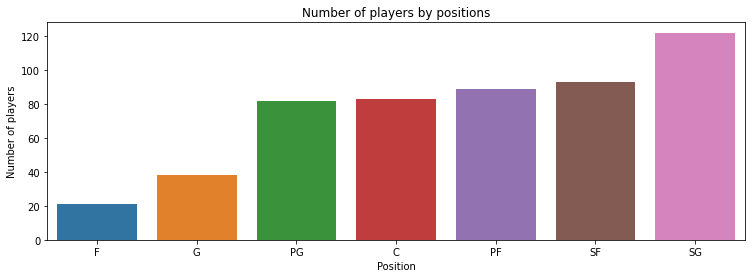

In [10]:
figsize(12.5,4)
positions=df['Position'].value_counts()
positions.sort_values(inplace=True)
bar=sns.barplot(x=positions.index, y=positions)
plt.xlabel("Position")
plt.ylabel("Number of players")
plt.title("Number of players by positions")
plt.show()

There are seven different positions: Shooting Guard (SG), SF (Small Forward), PF (Power Forward), C (Center), PG (Point Guard), G( Guard), F (Forward)

We plot the salary's means for each type of position.

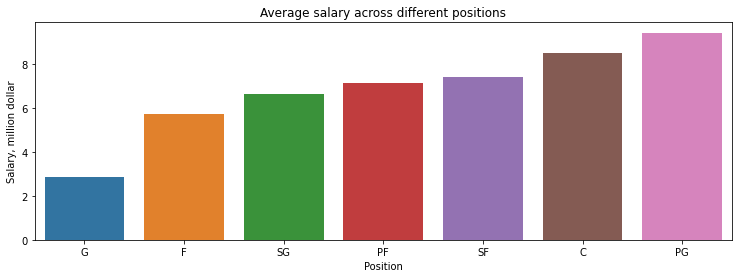

In [11]:
figsize(12.5,4)
salary=df.groupby('Position')['Salary'].mean()
salary.sort_values(inplace=True)
bar=sns.barplot(x=salary.index, y=salary)
plt.xlabel("Position")
plt.ylabel("Salary, million dollar")
plt.title("Average salary across different positions")
plt.show()

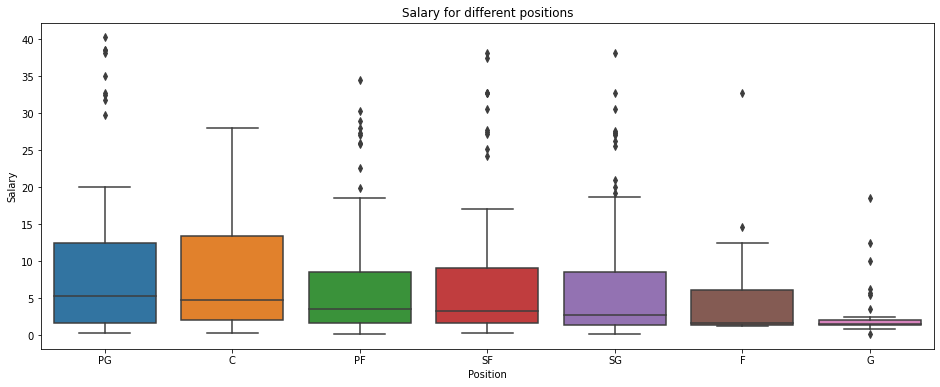

In [12]:
figsize(16,6)
my_order = df.groupby("Position")['Salary'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='Position', y='Salary', order=my_order)
plt.title("Salary for different positions")
plt.show()

In [13]:
df.groupby('Position')['Salary'].describe()

,count,mean,std,min,25%,50%,75%,max
Position,,,,,,,,
C,83.0,8.513441,8.346114,0.245686,2.069921,4.767000,13.449275,28.000000
F,21.0,5.725415,7.408607,1.187862,1.416852,1.678854,6.134520,32.700690
G,38.0,2.840689,3.590827,0.208509,1.378242,1.557155,1.989896,18.500000
PF,89.0,7.138192,8.326470,0.183115,1.620564,3.481986,8.556120,34.449964
PG,82.0,9.440179,10.629510,0.350189,1.620564,5.327564,12.407848,40.231758
SF,93.0,7.441571,9.499326,0.350189,1.620564,3.219480,9.073050,38.199000
SG,122.0,6.648962,8.125566,0.155647,1.425778,2.710817,8.480373,38.199000


# Part 1: Shooting Guard vs Point Guard

First, we filter out the data for SG and PG position. We also compute the pooled sample means and pooled sample variance as discussed in [1]

In [51]:
SG=df[df['Position']=='SG']['Salary']
PG=df[df['Position']=='PG']['Salary']
pooled_mean=np.r_[SG, PG].mean()
pooled_std=np.r_[SG, PG].std()
variance=2*pooled_std

Next, we set prior distributions on the parameters. We set the bounds for the standard deviations to be big enough so that it can catch a wide net.

In [57]:
with pm.Model() as model_1:
    mu_A=pm.Normal("mu_A", pooled_mean, sd=variance)
    mu_B=pm.Normal("mu_B", pooled_mean, sd=variance)
    std_A=pm.Uniform("std_A", 1/100, 100)
    std_B=pm.Uniform("std_B", 1/100, 100)
    nu_minus_1=pm.Exponential("nu-1", 1.0/29)
    

We fit the data into our model.

In [58]:
with model_1:
    obs_A=pm.StudentT("obs_A", mu=mu_A, lam=1.0/std_A**2, nu=nu_minus_1+1, observed=SG)
    obs_B=pm.StudentT("obs_B", mu=mu_B, lam=1.0/std_B**2, nu=nu_minus_1+1, observed=PG)
    start=pm.find_MAP()
    step=pm.Metropolis(vars=[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1=pm.sample(25000, step=step)
    burned_trace_1=trace_1[10000:]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 45 seconds.
The number of effective samples is smaller than 10% for some parameters.


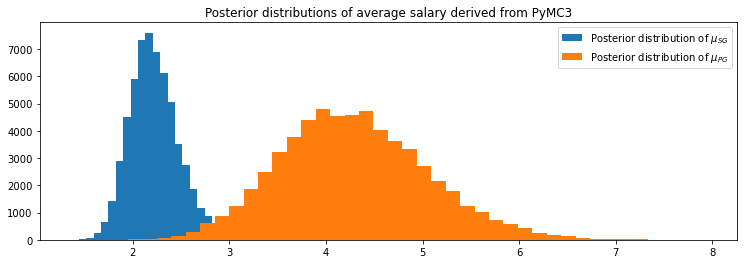

In [59]:
figsize(12.5, 4)
SG_mean=burned_trace_1['mu_A']
PG_mean=burned_trace_1['mu_B']
plt.hist(SG_mean, bins=40, label=r'Posterior distribution of $\mu_{SG}$')
plt.hist(PG_mean, bins=40, label=r'Posterior distribution of $\mu_{PG}$')
plt.title('Posterior distributions of average salary derived from PyMC3')
plt.legend()
plt.show()

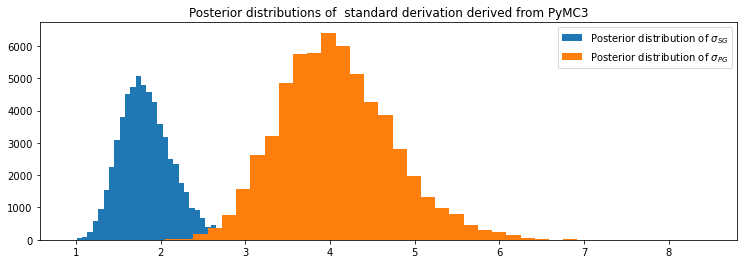

In [61]:
figsize(12.5, 4)
SG_std=burned_trace_1['std_A']
PG_std=burned_trace_1['std_B']
plt.hist(SG_std, bins=40, label=r'Posterior distribution of $\sigma_{SG}$')
plt.hist(PG_std, bins=40, label=r'Posterior distribution of $\sigma_{PG}$')
plt.title('Posterior distributions of  standard derivation derived from PyMC3')
plt.legend()
plt.show()

We apply the best test for ROPE=[-0.1, 0.1] and 95% HDI. First, we plot histogram of the difference with these ROPE and HDI. 

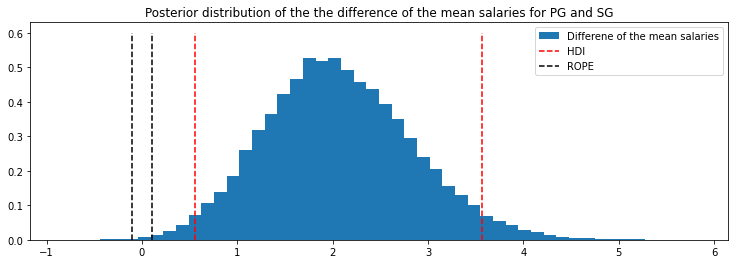

In [80]:
figsize(12.5, 4)
difference=PG_mean-SG_mean #difference of the means 
hdi=pm.stats.hpd(difference, hdi_prob=0.95) #the 95% HDI interval of the difference
rope=[-0.1, 0.1] #the ROPE region 
plt.hist(difference, bins=50, density=True, label='Differene of the mean salaries')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,0.6, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 0.6, linestyle='--', color='red')
plt.vlines(rope[0], 0, 0.6, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 0.6, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of the mean salaries for PG and SG')
plt.legend(loc='upper right')
plt.show()

In [81]:
hdi

array([0.5580346 , 3.57072747])

The probability that a PG player earn 50% more than an SG player is: 0.8830833333333333


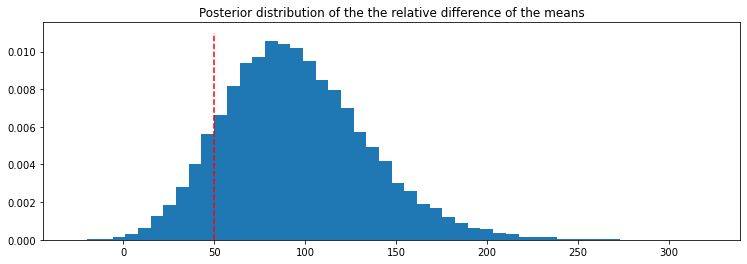

In [88]:
figsize(12.5, 4)
rel_difference=100*(PG_mean-SG_mean)/SG_mean #difference of the means 
prob=len(rel_difference[rel_difference>50])/len(rel_difference)
plt.hist(rel_difference, bins=50, density=True, label='Relative differene of the mean salaries')
plt.title('Posterior distribution of the the relative difference of the means')
plt.vlines(50, 0,0.011, linestyle='--', color='red', label='HDI')
print(f"The probability that a PG player earn 50% more than an SG player is: {prob}")
plt.show()

# Part 2: Small Forward and Power Foward

In [14]:
SF=df[df['Position']=='SF']['Salary']
PF=df[df['Position']=='PF']['Salary']
pooled_mean=np.r_[SF, PF].mean()
pooled_std=np.r_[SF, PF].std()
variance=2*pooled_std

In [15]:
pooled_mean=np.r_[SF, PF].mean()
pooled_std=np.r_[SF, PF].std()
variance=2*pooled_std

In [16]:
SF=df[df['Position']=='SF']['Salary']
PF=df[df['Position']=='PF']['Salary']
pooled_mean=np.r_[SF, PF].mean()
pooled_std=np.r_[SF, PF].std()

variance=2*pooled_std
with pm.Model() as model_2:
    mu_A=pm.Normal("mu_A", pooled_mean, sd=variance)
    mu_B=pm.Normal("mu_B", pooled_mean, sd=variance)
    std_A=pm.Uniform("std_A", 1/100, 100)
    std_B=pm.Uniform("std_B", 1/100, 100)
    nu_minus_1=pm.Exponential("nu-1", 1.0/29)

    obs_A=pm.StudentT("obs_A", mu=mu_A, lam=1.0/std_A**2, nu=nu_minus_1+1, observed=SF)
    obs_B=pm.StudentT("obs_B", mu=mu_B, lam=1.0/std_B**2, nu=nu_minus_1+1, observed=PF)
    start=pm.find_MAP()
    step=pm.Metropolis(vars=[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_2=pm.sample(25000, step=step)
    burned_trace_2=trace_2[10000:]
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 47 seconds.
The number of effective samples is smaller than 10% for some parameters.


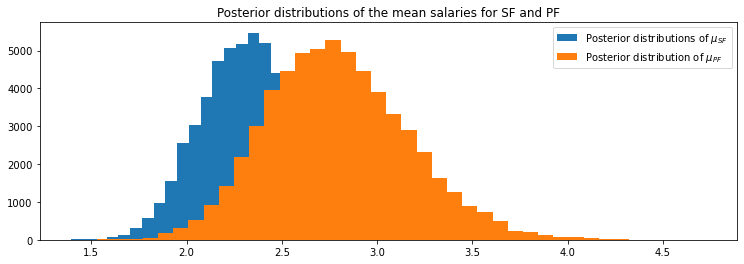

In [17]:
figsize(12.5, 4)
SF_mean=burned_trace_2['mu_A']
PF_mean=burned_trace_2['mu_B']
plt.hist(SF_mean, bins=40, label=r'Posterior distributions of $\mu_{SF}$')
plt.hist(PF_mean, bins=40, label=r'Posterior distribution of $\mu_{PF}$')
plt.title('Posterior distributions of the mean salaries for SF and PF')
plt.legend()
plt.show()

/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


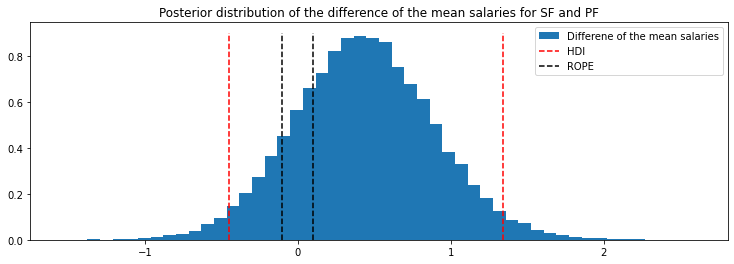

In [18]:
figsize(12.5, 4)
difference=PF_mean-SF_mean #difference of the means 
hdi=pm.stats.hpd(difference, hdi_prob=0.95) #the 95% HDI interval of the difference
rope=[-0.1, 0.1] #the ROPE region 
plt.hist(difference, bins=50, density=True, label='Differene of the mean salaries')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,0.9, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 0.9, linestyle='--', color='red')
plt.vlines(rope[0], 0, 0.9, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 0.9, linestyle='--', color='black')
plt.title('Posterior distribution of the difference of the mean salaries for SF and PF')
plt.legend(loc='upper right')
plt.show()

In [19]:
hdi

array([-0.44822444,  1.34450148])

# Part 3: Center vs Power Forward

In [26]:
C=df[df['Position']=='C']['Salary']
PF=df[df['Position']=='PF']['Salary']
pooled_mean=np.r_[C, PF].mean()
pooled_std=np.r_[C, PF].std()

variance=2*pooled_std
with pm.Model() as model_3:
    mu_A=pm.Normal("mu_A", pooled_mean, sd=variance)
    mu_B=pm.Normal("mu_B", pooled_mean, sd=variance)
    std_A=pm.Uniform("std_A", 1/100, 100)
    std_B=pm.Uniform("std_B", 1/100, 100)
    nu_minus_1=pm.Exponential("nu-1", 1.0/29)

    obs_A=pm.StudentT("obs_A", mu=mu_A, lam=1.0/std_A**2, nu=nu_minus_1+1, observed=C)
    obs_B=pm.StudentT("obs_B", mu=mu_B, lam=1.0/std_B**2, nu=nu_minus_1+1, observed=PF)
    start=pm.find_MAP()
    step=pm.Metropolis(vars=[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_3=pm.sample(25000, step=step)
    burned_trace_3=trace_3[10000:]
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 44 seconds.
The number of effective samples is smaller than 10% for some parameters.


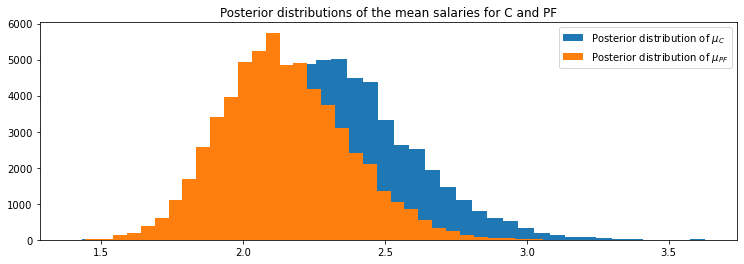

In [27]:
figsize(12.5, 4)
C_mean=burned_trace_3['mu_A']
PF_mean=burned_trace_3['mu_B']
plt.hist(SF_mean, bins=40, label=r'Posterior distribution of $\mu_{C}$')
plt.hist(SG_mean, bins=40, label=r'Posterior distribution of $\mu_{PF}$')
plt.title('Posterior distributions of the mean salaries for C and PF')
plt.legend()
plt.show()

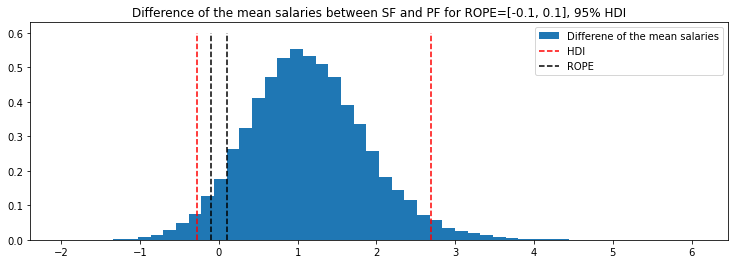

In [46]:
figsize(12.5, 4)
difference=C_mean-PF_mean #difference of the means 
prob=95
hdi=pm.stats.hpd(difference, hdi_prob=prob/100) #the 95% HDI interval of the difference
rope=[-0.1, 0.1] #the ROPE region 
plt.hist(difference, bins=50, density=True, label='Differene of the mean salaries')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,0.6, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 0.6, linestyle='--', color='red')
plt.vlines(rope[0], 0, 0.6, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 0.6, linestyle='--', color='black')
plt.title(f'Difference of the mean salaries between SF and PF for ROPE={rope}, {prob}% HDI')
plt.legend(loc='upper right')
plt.show()

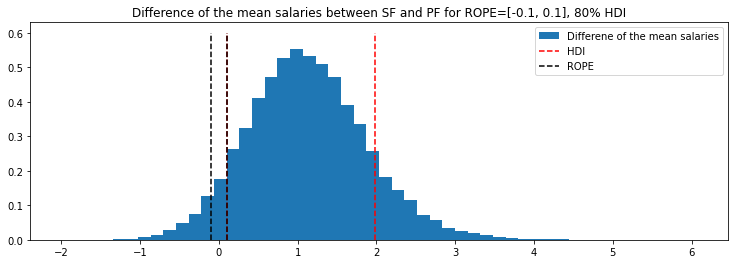

In [47]:
figsize(12.5, 4)
difference=C_mean-PF_mean #difference of the means 
prob=80
hdi=pm.stats.hpd(difference, hdi_prob=prob/100) #the 95% HDI interval of the difference
rope=[-0.1, 0.1] #the ROPE region 
plt.hist(difference, bins=50, density=True, label='Differene of the mean salaries')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,0.6, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 0.6, linestyle='--', color='red')
plt.vlines(rope[0], 0, 0.6, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 0.6, linestyle='--', color='black')
plt.title(f'Difference of the mean salaries between SF and PF for ROPE={rope}, {prob}% HDI')
plt.legend(loc='upper right')
plt.show()